In [15]:
import os
import numpy as np
import pandas as pd
from typing import Tuple, Dict
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [16]:
df = pd.read_csv('/datasets/Churn.csv')

In [36]:
#Analisando colunas para ver com utilizarei 

print(df.shape)
print(df.head(5))
print(df.info())


(10000, 13)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  
0        101348.88  
1        112542.58  
2        113931.57  
3         93826.63  
4         79084.10  
<class 'pandas.core.

In [18]:


y = df.pop('Exited')
X = df.drop(columns=['Surname'])




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12345)

X_train = X_train.copy()
X_test = X_test.copy()


Usei as colunas 'CreditScore', 'geography_le', 'Age', 'Balance', 'IsActiveMember', 'NumOfProducts', 'Exited', 'HasCrCard']], como referencia para arvore
Usei o labelencoder na coluna geography para poder substituir cada categoria por numeros.
Exemplo: ["France", "Spain", "Germany"] → [0, 2, 1].

Criei uma funçao para o frequency enconde, porem fiquei na duvida se eu deveria usar o "Smote"

In [19]:
def frequency_encode(train_series, test_series):
    freqs = train_series.value_counts(normalize=True)
    train_encoded = train_series.map(freqs)
    test_encoded = test_series.map(freqs).fillna(0)  
    return train_encoded, test_encoded

In [20]:

categorical_cols = ['Gender', 'Geography']
for col in categorical_cols:
    X_train_enc, X_test_enc = frequency_encode(X_train[col], X_test[col])
    X_train.loc[:, col] = X_train_enc
    X_test.loc[:, col] = X_test_enc


usei metodo pop para remover a coluna exited do df
Esse trecho separa as informações que vão ser usadas para prever (df, que virou X). Depois divide em treino (90%) e teste (10%), garantindo que  possa avaliar se o modelo aprendeu bem sem decorar os dados.


In [21]:
X_train

,RowNumber,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3376,3377,15721582,644,0.250625,0.453875,40,4.0,77270.08,2,1,1,115800.10
1315,1316,15734634,607,0.249375,0.453875,27,5.0,100912.19,1,0,0,7631.27
2552,2553,15756560,599,0.249375,0.453875,46,7.0,81742.84,2,1,0,83282.21
511,512,15761043,632,0.250625,0.453875,38,6.0,86569.76,2,1,0,98090.91
1888,1889,15663921,429,0.500000,0.546125,60,7.0,0.00,2,1,1,163691.48
...,...,...,...,...,...,...,...,...,...,...,...,...
2360,2361,15670205,518,0.250625,0.453875,41,5.0,110624.99,1,1,0,89327.67
4499,4500,15773322,536,0.250625,0.453875,44,4.0,121898.82,1,0,0,131007.18
1030,1031,15681174,730,0.500000,0.546125,39,1.0,116537.60,1,0,0,145679.60
700,701,15803457,750,0.500000,0.453875,32,5.0,0.00,2,1,0,95611.47


##oversampling da classe minoritária

In [22]:




counts = y_train.value_counts()
minor_class = counts.idxmin()
major_class = counts.idxmax()

X_min = X_train[y_train == minor_class]
y_min = y_train[y_train == minor_class]

X_maj = X_train[y_train == major_class]
y_maj = y_train[y_train == major_class]


X_min_over = X_min.sample(counts[major_class], replace=True, random_state=12345)
y_min_over = y_min.sample(counts[major_class], replace=True, random_state=12345)


X_train_bal = pd.concat([X_maj, X_min_over])
y_train_bal = pd.concat([y_maj, y_min_over])






In [27]:
X_train_bal = X_train_bal.fillna(0)
X_test = X_test.fillna(0)

In [29]:



model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=12345
)

model.fit(X_train_bal, y_train_bal)







RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=12345)

In [30]:

y_proba = model.predict_proba(X_test)[:, 1]



In [31]:

prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_thresh = thresholds[f1_scores.argmax()]

y_pred_adj = (y_proba >= best_thresh).astype(int)

print("Melhor threshold:", best_thresh)
print("F1 ajustado:", f1_score(y_test, y_pred_adj))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adj))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_adj))


Melhor threshold: 0.5390339615863275
F1 ajustado: 0.6491646778042959
ROC AUC: 0.8648494411206274

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      1593
           1       0.63      0.67      0.65       407

    accuracy                           0.85      2000
   macro avg       0.77      0.78      0.78      2000
weighted avg       0.86      0.85      0.85      2000

Matriz de confusão:
 [[1434  159]
 [ 135  272]]


avalia o equilíbrio entre detectar corretamente churns

Minha conclusão sobre o treinamento de modelo foi, que ele ficou "aceitavel" porém acredito que com melhoras deixo ele mais "fiel"

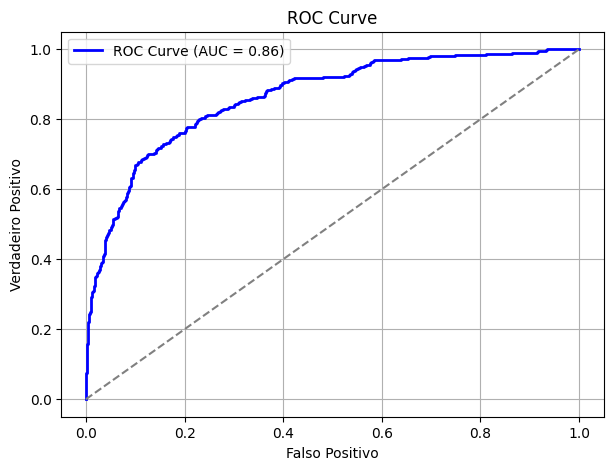

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Importância das Features

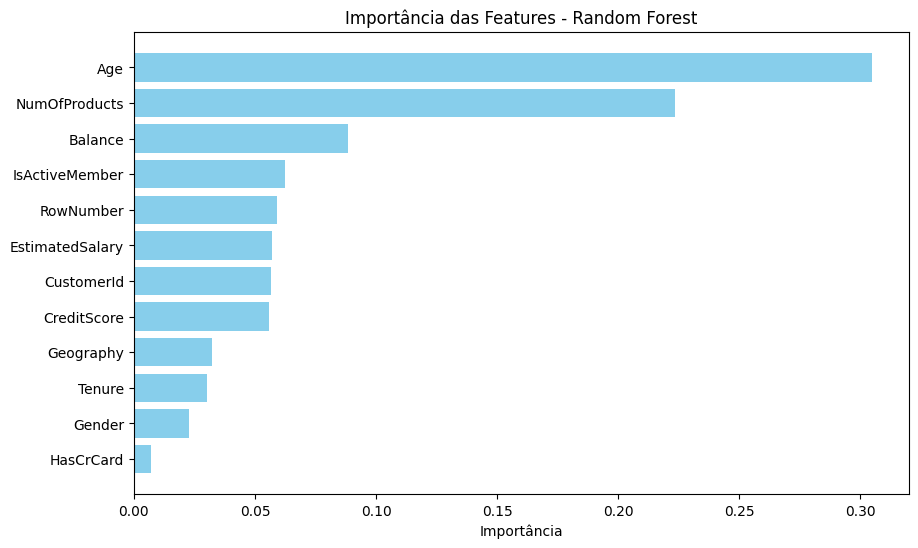

In [40]:
importances = model.feature_importances_
feature_names = X_train_bal.columns


feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.show()